# Dataset

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_individuals import prepare, germanBats
import matplotlib.pyplot as plt
import torch
import numpy as np
import tqdm
import pickle

classes = germanBats

In [2]:
patch_len = 44                               # 88 bei 44100, 44 bei 22050 = 250ms ~ 25ms
resize = (128, 64)

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len, resize=resize)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.35it/s]


In [3]:
with open('../call_nocall.indices', 'rb') as file:
    indices, labels = pickle.load(file)
    train_indices = indices[0]
    test_indices = indices[1]
    val_indices = indices[2]
    
    X_train = X_train[train_indices]
    X_test = X_test[test_indices]
    X_val = X_val[val_indices]
    
    Y_train = Y_train[train_indices]
    Y_test = Y_test[test_indices]
    Y_val = Y_val[val_indices]

In [4]:
print("Total calls:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total calls: 33868
(19839, 64, 128) (19839,)


In [5]:
X = np.concatenate([X_train, X_test, X_val])

# Model

In [67]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [68]:
# Batch size during training
batch_size = 256

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 16

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [69]:
from torchsummary import summary

In [70]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, (4, 8), 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    

summary(Generator(ngpu).cuda(), input_size=(nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 8]         131,072
       BatchNorm2d-2            [-1, 256, 4, 8]             512
              ReLU-3            [-1, 256, 4, 8]               0
   ConvTranspose2d-4           [-1, 128, 8, 16]         524,288
       BatchNorm2d-5           [-1, 128, 8, 16]             256
              ReLU-6           [-1, 128, 8, 16]               0
   ConvTranspose2d-7           [-1, 64, 16, 32]         131,072
       BatchNorm2d-8           [-1, 64, 16, 32]             128
              ReLU-9           [-1, 64, 16, 32]               0
  ConvTranspose2d-10           [-1, 32, 32, 64]          32,768
      BatchNorm2d-11           [-1, 32, 32, 64]              64
             ReLU-12           [-1, 32, 32, 64]               0
  ConvTranspose2d-13           [-1, 1, 64, 128]             512
             Tanh-14           [-1, 1, 

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 4
            nn.Conv2d(ndf * 8, 1, (4, 8), 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

summary(Discriminator(ngpu).cuda(), input_size=(1, 64, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 64]             512
         LeakyReLU-2           [-1, 32, 32, 64]               0
            Conv2d-3           [-1, 64, 16, 32]          32,768
       BatchNorm2d-4           [-1, 64, 16, 32]             128
         LeakyReLU-5           [-1, 64, 16, 32]               0
            Conv2d-6           [-1, 128, 8, 16]         131,072
       BatchNorm2d-7           [-1, 128, 8, 16]             256
         LeakyReLU-8           [-1, 128, 8, 16]               0
            Conv2d-9            [-1, 256, 4, 8]         524,288
      BatchNorm2d-10            [-1, 256, 4, 8]             512
        LeakyReLU-11            [-1, 256, 4, 8]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 697,728
Trainable params:

-1.0 1.0 (33868, 1, 64, 128)


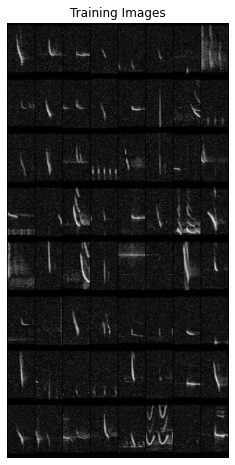

In [12]:
np_X = np.expand_dims(X, axis=1)
X_norm = 2 * (np_X / np_X.max()) - 1
print(X_norm.min(), X_norm.max(), X_norm.shape)
data = TensorDataset(torch.Tensor(X_norm))
dataloader = DataLoader(data, batch_size=batch_size)

# Plot some training images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu().permute(1,2,0).rot90())

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(16, 256, kernel_size=(4, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
import wandb

wandb.init(project="BAT-gan", entity="frankfundel")

wandb.config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size
}

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wandb.log({
                "loss_D": errD.item(),
                "loss_G": errG.item(),
            })
    
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/25][0/133]	Loss_D: 1.3216	Loss_G: 7.3396	D(x): 0.7579	D(G(z)): 0.5676 / 0.0025
[0/25][50/133]	Loss_D: 0.9573	Loss_G: 3.3485	D(x): 0.7007	D(G(z)): 0.4060 / 0.0494
[0/25][100/133]	Loss_D: 1.3969	Loss_G: 0.7038	D(x): 0.3469	D(G(z)): 0.1490 / 0.5180
[1/25][0/133]	Loss_D: 1.0971	Loss_G: 1.0403	D(x): 0.4946	D(G(z)): 0.2562 / 0.4039
[1/25][50/133]	Loss_D: 0.8515	Loss_G: 1.3976	D(x): 0.6081	D(G(z)): 0.2680 / 0.2760
[1/25][100/133]	Loss_D: 1.3035	Loss_G: 2.8674	D(x): 0.6776	D(G(z)): 0.5607 / 0.0641
[2/25][0/133]	Loss_D: 1.1617	Loss_G: 3.6732	D(x): 0.7323	D(G(z)): 0.5361 / 0.0335
[2/25][50/133]	Loss_D: 1.4243	Loss_G: 0.6525	D(x): 0.3051	D(G(z)): 0.1282 / 0.5313
[2/25][100/133]	Loss_D: 1.3567	Loss_G: 4.2412	D(x): 0.8471	D(G(z)): 0.6620 / 0.0191
[3/25][0/133]	Loss_D: 1.1851	Loss_G: 3.3786	D(x): 0.6927	D(G(z)): 0.5293 / 0.0456
[3/25][50/133]	Loss_D: 1.1037	Loss_G: 1.6768	D(x): 0.4522	D(G(z)): 0.2152 / 0.2078
[3/25][100/133]	Loss_D: 1.2419	Loss_G: 4.6062	D(x): 0.7480	D(G

In [18]:
wandb.finish()

loss_D,▅▃▄▅▆▄▅▄▆▅▃▄▄▅▇█▂▇▂▁▁▅▁▂▅▄▂▃▂▅▄▄▄▃▂▂▄▄▃▃
loss_G,█▄▁▃▁▄▅▂▄▄▃▂▂▂▅▄▄▆▃▆▃▃▄▃▄▅▅▅▅▆▂▆▄▄▃▃▃▄▂▃
loss_D,1.024
loss_G,2.24396


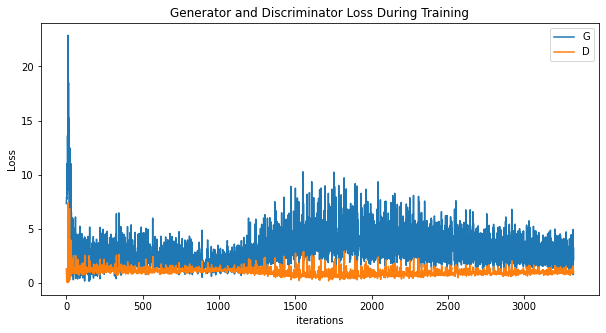

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

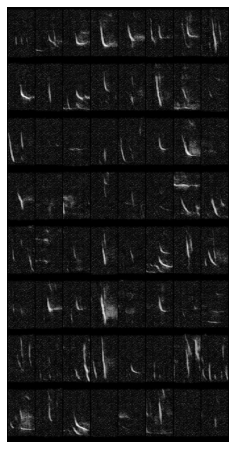

In [20]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0).rot90(), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [21]:
c_g = torch.jit.script(netG)
c_d = torch.jit.script(netD)
torch.jit.save(c_g, 'netG.pt')
torch.jit.save(c_d, 'netD.pt')

In [ ]:
x = torch.randn(batch_size, nz, 1, 1, requires_grad=True).cuda()
torch_out = netG(x)

torch.onnx.export(netG,                      # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "batgan.onnx",             # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [95]:
from pytorch2keras.converter import pytorch_to_keras

x = torch.randn(1, nz, 1, 1, requires_grad=True).cpu()
net = torch.jit.load("dim_16/netG.pt").cpu()
#plt.imshow(net(x).data.numpy()[0][0])

k_model = pytorch_to_keras(net, x, [(nz, 1, 1)], verbose=True, name_policy='renumerate')
k_model.save('keras.h5')

graph(%input_0 : Float(1, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %main.0.weight : Float(16, 256, 4, 8, strides=[8192, 32, 8, 1], requires_grad=0, device=cpu),
      %main.1.running_mean : Float(256, strides=[1], requires_grad=0, device=cpu),
      %main.1.running_var : Float(256, strides=[1], requires_grad=0, device=cpu),
      %main.1.weight : Float(256, strides=[1], requires_grad=0, device=cpu),
      %main.1.bias : Float(256, strides=[1], requires_grad=0, device=cpu),
      %main.3.weight : Float(256, 128, 4, 4, strides=[2048, 16, 4, 1], requires_grad=0, device=cpu),
      %main.4.running_mean : Float(128, strides=[1], requires_grad=0, device=cpu),
      %main.4.running_var : Float(128, strides=[1], requires_grad=0, device=cpu),
      %main.4.weight : Float(128, strides=[1], requires_grad=0, device=cpu),
      %main.4.bias : Float(128, strides=[1], requires_grad=0, device=cpu),
      %main.6.weight : Float(128, 64, 4, 4, strides=[1024, 16, 4, 1], requir

In [96]:
from tensorflow import keras
import tensorflowjs as tfjs
model = keras.models.load_model("keras.h5")
tfjs.converters.save_keras_model(model, "tfjsmodel")